<a href="https://colab.research.google.com/github/lbovet8/phys152-2026/blob/main/Exercises/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Exercise 1: Parameter Counting and Memory Management (30 points)

Show your work for the following short-answer questions.

## part 1(a) Parameter counting (10 points)

A more advanced version of the CNN we trained may have three convolutional layers, each with $3 \times 3$ kernels, a stride of 2, and "same" padding.
The lowest (first) `Conv2D` layer outputs 100 feature maps, the middle layer outputs 200, and the top (last) one outputs 400 maps.
These operate on input images that are RGB images of $200 \times 300$ pixels.

Show that this network will comprise more than 800,000 parameters.

### Answer

The number of parameters in a CNN can be determined with

number_parameters = out_channels * (in_channels * kernel_height * kernel_width + bias)

where bias = 1.

For layer 1, we have out_channels = 100 (feature maps), in_channels = 3 (RGB),  kernel_height = kernel_width = 3. So after layer 1 we have:

number_parameters1 = 100 * (3 * 3 * 3 + 1) = 2 800.

For layer 2, we have out_channels = 200 (feature maps), in_channels = 100 (feature maps from layer 1),  kernel_height = kernel_width = 3. So after layer 2 we have:

number_parameters2 = 200 * (100 * 3 * 3 + 1) = 180 200.

For layer 3, we have out_channels = 400 (feature maps), in_channels = 200 (feature maps from layer 2),  kernel_height = kernel_width = 3. So after layer 3 we have:

number_parameters3 = 400 * (200 * 3 * 3 + 1) = 720 400.

With that we have:

number_parameters_tot = number_parameters1 + number_parameters2 + number_parameters3 = 903 400.


## part 1(b) Memory management (10 points)

The parameters in part 1(a) are typically represented using 32-bit floating point numbers.
Show that this network will require at least 12 MB of RAM when making a *prediction* for a single data instance (input image).

### Answer
1byte = 8 bits so 32 bits = 4 bytes.

One parameters is represented with 32bits (4bytes) so for the total parameters we have:

bytes_parameters = 903 400 * 4bytes = 3 613 600bytes = 3.6MB.

Now we have to go through the layers. Same padding ensures that we add zeros on the side so we maximize the possible output (or we have the same size as input but that would only work for stride=1?) And with stride = 2 we approximately halve the input size (that's what an example does in O'Reilly Chapt 12).

For layer 1, we have input size 200x300, so after the first convolution we end up with size 100x150. This multiplies by the number of features maps (here 100). So in total we need:

bytes_layer1 = 100 * 150 * 100 * 4bytes = 6MB.

For layer 2, we have input size 100x150, so after the second convolution we end up with size 50x75. This multiplies by the number of features maps (here 200). So in total we need:

bytes_layer2 = 50 * 75 * 200 * 4bytes = 3MB.

For layer 3, we have input size 50x75, so after the third convolution we end up with size 25x38. This multiplies by the number of features maps (here 400). So in total we need:

bytes_layer3 = 25 * 38 * 400 * 4bytes = 1.5MB.

Adding up everthing, we need a total of:

bytes_tot = bytes_parameters + bytes_layer1 + bytes_layer2 + bytes_layer3 = 14.1MB.


## part 1(c) Memory management in training(5 points)

How much RAM is needed if mini-batch *training* is used with batches of 50 images? (*Hint*: it is at least 500 MB.)

### Answer

We need again for the parameters bytes_parameters = 3.6MB. But now we need to multiply the activation for the layers by the number of images per batch.

bytes_layers = num_images * (bytes_layer1 + bytes_layer2 + bytes_layer3) = 50 * 10.5MB = 525MB.

However, this is only the forward propagation and for training we are also going backwards using the gradient, which needs additional RAM. Adding up everything, we definitly need more than 500MB.


## part 1(d) RNN dimensions (5 points)

The input to an RNN layer must have three dimensions.
What does each input dimension represent?
And what do the outputs of the RNN layer represent?

### Answer

The inputs for a RNN represent the batch size (how many sequences are given), time steps (how long is the sequence) and features (properties of one time steps). The output is either the last hidden (batch size, hidden units) state or optionally the hidden state for each time step (batch size, time step, hidden units).

# Exercise 2: CNN Training for Quantum State Classification (35 points)

In this exercise you will train a CNN on a dataset of quantum states for a particle in a 1-d box of length $L$.

The goal is to identify the quantum index of the eigenfunction: $n=1,2,3,\ldots$, or the dominant eigenfunction for a mixed state.

*Bonus question: why is the CNN a better choice for this challenge than a RNN?*



## Generate dataset

We give you the dataset generator so that everyone has a similar dataset.

The basic spatial eigenfunction is
$\psi(x) = \sqrt{\frac{2}{L}} \sin(n\pi x/L),$
but that is too simple to learn, so we add some Gaussian noise to the function to make it challenging.

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

np.random.seed(42)
torch.manual_seed(42)

# Parameters for the simulation
NUM_POINTS = 256          # points in the spatial function
NUM_CLASSES = 5           # quantum numbers n = 1 through 5
NOISE_STD = 0.3               # std of Gaussian noise to add

def generate_noisy_pinb(n_samples, noise_std=NOISE_STD, L=1.0):
    """Generate noisy wavefunctions for Particle In Box
       with known box length L."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        n = np.random.randint(1, NUM_CLASSES + 1)          # n = 1…5
        psi = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1                                       # class index 0…4
    return X, y

def make_data_loaders(generate_fn, n_train=5000, n_val=1000, batch_size=64):
    """Generate data with some `generate_fn` and wrap in DataLoaders."""
    X_train, y_train = generate_fn(n_train)
    X_val,   y_val   = generate_fn(n_val)

    # Reshape to (N, 1, NUM_POINTS) for Conv1d
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
    y_val   = torch.tensor(y_val,   dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    return (DataLoader(train_ds, batch_size, shuffle=True),
            DataLoader(val_ds,   batch_size))

train_loader, val_loader = make_data_loaders(generate_noisy_pinb)


Using device: cuda


## part 2(a): Check the dataset (5 points)

Plot the first 5 inputs in the `train_loader` as spatial functions, just to check that they look reasonable.

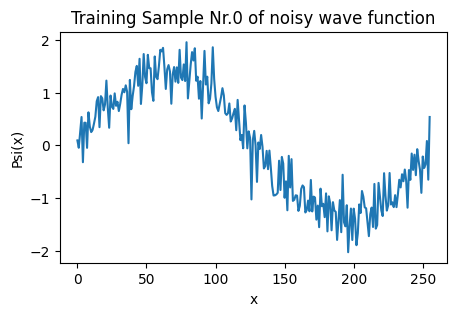

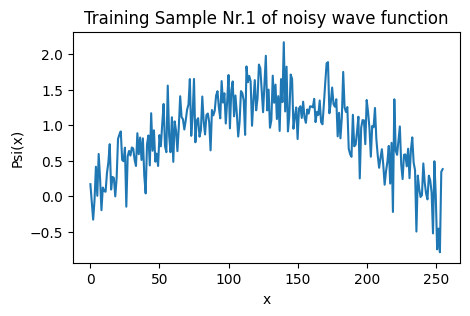

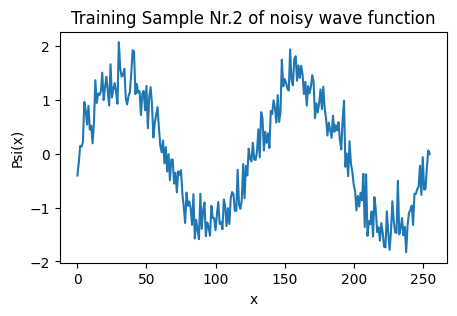

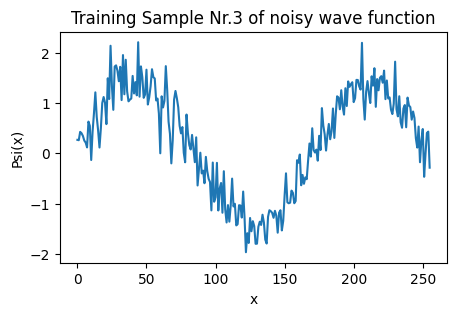

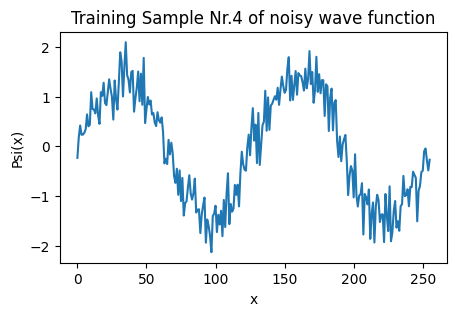

In [3]:
# Look at batch 0 to extract the first few samples
for i, (X_batch, y_batch) in enumerate(train_loader):  # x shape: (batch, 1, NUM_POINTS=256)
    if i == 0:
      j = 0
      while j < 5:
          plt.figure(figsize=(5, 3))
          plt.plot(X_batch[j, 0, :]) # index 0 for channel because there is only one
          plt.xlabel("x")
          plt.ylabel("Psi(x)")
          plt.title(f"Training Sample Nr.{j} of noisy wave function")
          plt.show()

          j += 1

## part 2(b): Construct CNN (10 points)

The CNN is based on the `Conv1d` object in PyTorch.

We have set up the first layer and the third layer.
- Now you add the second convolutional layer with a $5\times 5$ kernel and padding = 2.
- Explain why the last convolutional layer uses the *average* pooling method instead of the *maximum* pooling method.
- Explain what is happening with the `squeeze` in the `forward` function.



In [4]:
class WavefunctionCNN(nn.Module):
    """1-D CNN particle-in-a-box wavefunctions."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Add missing hidden layer here
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, NUM_POINTS)
        x = self.features(x)
        x = x.squeeze(-1)                     # (batch, 64)
        return self.classifier(x)


If we would take the maximum pooling method in the last layer, we would emphasize the peaks of the wave function too much. For a good classification, it is better to look at the whole shape of the wavefunction. By this, we get more helpful information (number of nodes, peaks etc.) for a good classification.

x.squeeze adjusts the dimension accordingly for this problem. Before we have # x shape: (batch, 1, NUM_POINTS), after we have # x shape: (batch, 64) which is dimensionally correct to be an input for self.classifier(x) which is nn-Linear here.

## part 2(c): Train CNN (5 points)

- Pick a reasonable criterion and optimizer for the CNN training and add them to the `train_model` function.
- What is the role of the `logits.argmax(1)` call inside the mini-batch training?
- Then train the CNN on the data loaders and plot the evolution of the loss and accuracy as a function of epoch.



In [5]:
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    # Add your criterion and optimizer here
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            # What does logits.argmax(1) do here?
            correct += (logits.argmax(1) == y_batch).sum().item()
            total += X_batch.size(0)

        history["train_loss"].append(running_loss / total)
        history["train_acc"].append(correct / total)

        # validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (logits.argmax(1) == y_batch).sum().item()
                val_total += X_batch.size(0)

        history["val_loss"].append(val_loss / val_total)
        history["val_acc"].append(val_correct / val_total)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  "
                  f"train_loss={history['train_loss'][-1]:.4f}  "
                  f"val_acc={history['val_acc'][-1]:.3f}")

    return history

In the mini-batch training, logits are the outputs of the last layer from our model as (64, num_classes=5). Demanding logits.argmax(1) we are going over the class number dimension which describes the score for a classification to each possible state and returns the index with the best score. In the end we are choosing the best classification here.

In [6]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    #plt.savefig('training_curves_no_dropout.png', dpi=150)
    #print("\nTraining curves saved to 'training_curves_no_dropout.png'")
    #plt.close()

Epoch   1/20  train_loss=1.1840  val_acc=0.722
Epoch   5/20  train_loss=0.1212  val_acc=1.000
Epoch  10/20  train_loss=0.0088  val_acc=1.000
Epoch  15/20  train_loss=0.0025  val_acc=1.000
Epoch  20/20  train_loss=0.0010  val_acc=1.000


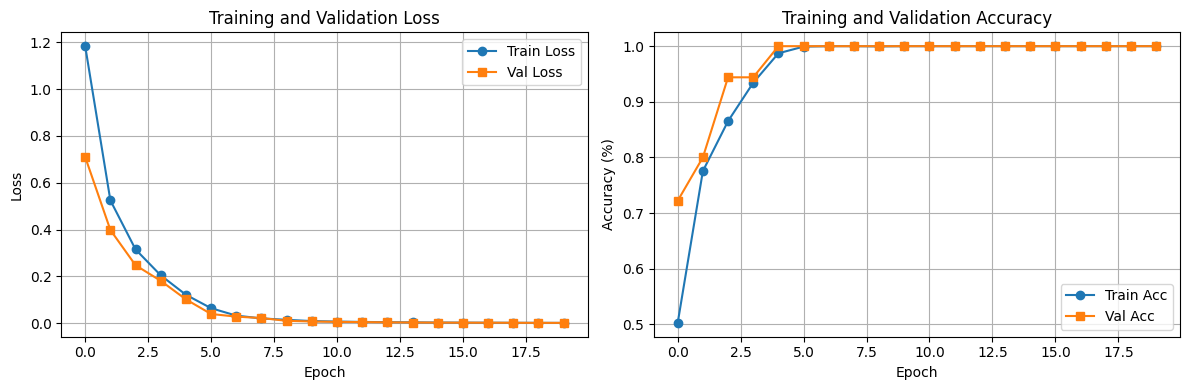

In [7]:
# Write your code here to train the network using the function definitions above.
# Use the train_loader and val_loader data.
# You can use the history output to make the plots of loss and accuracy
train_loader1, val_loader1 = make_data_loaders(generate_noisy_pinb)

# Create and load model
model1 = WavefunctionCNN().to(DEVICE)
history1 = train_model(model1, train_loader1, val_loader1, epochs=20, lr=0.001)

#print(history1)

plot_training_curves(history1['train_loss'], history1['val_loss'], history1['train_acc'], history1['val_acc'])

## part 2(d) (5 points)

The next challenge for the CNN is to identify the different eigenstates even with varied box lengths.

To that end, we generate a new dataset with L values varying from 0.5 to 2.0, and we add the same Gaussian noise to each curve.

Add code to retrain the CNN using these new data and evaluate the performance. How do the results compare to the results from part 2(c)?

In [8]:
def generate_varying_L(n_samples, L_range=(0.5, 2.0), noise_std=0.3):
    """Generate wavefunctions with random box length L."""
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        L = np.random.uniform(*L_range)
        n = np.random.randint(1, NUM_CLASSES + 1)
        # We always sample x in [0, L_max] and zero-pad outside [0, L]
        x = np.linspace(0, L_range[1], NUM_POINTS, endpoint=False)
        psi = np.where(x <= L,
                       np.sqrt(2 / L) * np.sin(n * np.pi * x / L),
                       0.0)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1
    return X, y


Epoch   1/20  train_loss=1.2136  val_acc=0.614
Epoch   5/20  train_loss=0.2861  val_acc=0.956
Epoch  10/20  train_loss=0.0918  val_acc=0.982
Epoch  15/20  train_loss=0.0468  val_acc=0.988
Epoch  20/20  train_loss=0.0422  val_acc=0.995


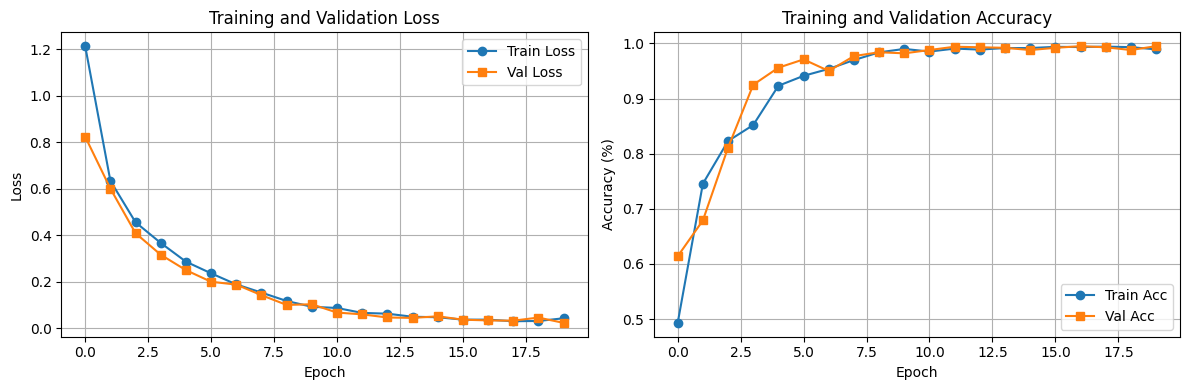

In [9]:
# Write your code here to
# - put the generate_varying_L data into data loaders
train_loader2, val_loader2 = make_data_loaders(generate_varying_L)
# - use those data to retrain the CNN
model2 = WavefunctionCNN().to(DEVICE)
history2 = train_model(model2, train_loader2, val_loader2, epochs=20, lr=0.001)

# - use the history output to make the plots of loss and accuracy
plot_training_curves(history2['train_loss'], history2['val_loss'], history2['train_acc'], history2['val_acc'])


## part 2(e) (5 points)

Now for the biggest challenge of all.

Each sample is now a normalized superposition

$$\Psi(x) = \alpha\,\psi_m(x) + \beta\,\psi_n(x), \qquad \alpha^2 + \beta^2 = 1$$

where $m \neq n$ are drawn at random and $|\alpha| > |\beta|$ by construction.
The label is the **dominant** quantum number $m$.

The CNN will have to figure out the dominant quantum number.

This is significantly harder than the previous challenges because the CNN must disentangle overlapping spatial
frequencies.

Use the function below to generate the data; then retrain the CNN to find the dominant quantum number.


In [10]:
def generate_superposition(n_samples, L=1.0, noise_std=0.05):
    """Generate superpositions of two states; label = dominant n."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        # Pick two distinct quantum numbers
        m, n = np.random.choice(range(1, NUM_CLASSES + 1), size=2, replace=False)

        # Random mixing angle; ensure |alpha| > |beta|
        theta = np.random.uniform(0, np.pi / 4)     # alpha = cos θ ≥ cos(π/4) ≈ 0.71
        alpha, beta = np.cos(theta), np.sin(theta)

        psi_m = np.sqrt(2 / L) * np.sin(m * np.pi * x / L)
        psi_n = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        psi   = alpha * psi_m + beta * psi_n

        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = m - 1        # dominant quantum number

    return X, y


Epoch   1/20  train_loss=1.3350  val_acc=0.581
Epoch   5/20  train_loss=0.8326  val_acc=0.786
Epoch  10/20  train_loss=0.3508  val_acc=0.858
Epoch  15/20  train_loss=0.2572  val_acc=0.901
Epoch  20/20  train_loss=0.2131  val_acc=0.907


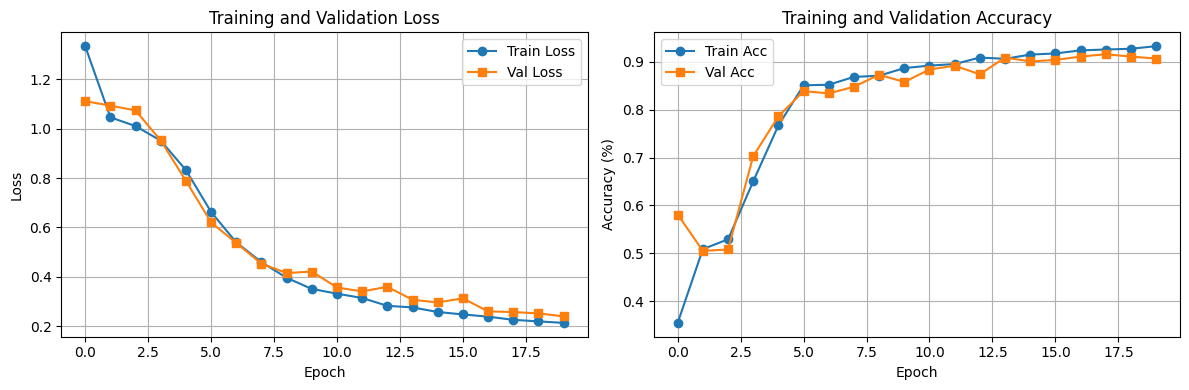

In [11]:
# Write your code here to
# - put the generate_superposition data into data loaders
train_loader3, val_loader3 = make_data_loaders(generate_superposition)

# - use those data to retrain the CNN and plot results
model3 = WavefunctionCNN().to(DEVICE)
history3 = train_model(model3, train_loader3, val_loader3, epochs=20, lr=0.001)
plot_training_curves(history3['train_loss'], history3['val_loss'], history3['train_acc'], history3['val_acc'])

## part 2(f) (5 points)

- Use `scikit-learn.confusion_matrix` to display the confusion matrix for the 5 labeled classes.
- Which states were most easily confused? Explain the reason for the confusion, using your knowledge of quantum mechanics.

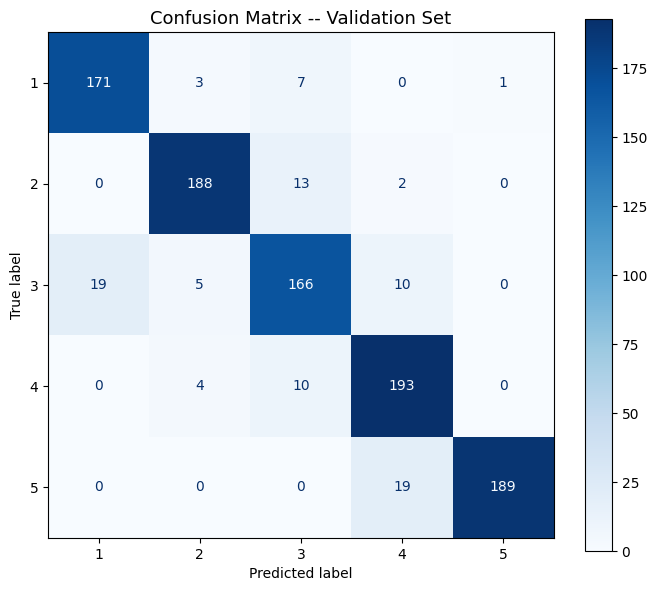


Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.94      0.92       182
           2       0.94      0.93      0.93       203
           3       0.85      0.83      0.84       200
           4       0.86      0.93      0.90       207
           5       0.99      0.91      0.95       208

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [12]:
all_preds, all_labels = [], []
model3.eval()
with torch.no_grad():
    for wf, labels in val_loader3:
        logits = model3(wf.to(DEVICE))
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["1","2","3","4","5"])
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix -- Validation Set", fontsize=13)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["1","2","3","4","5"]))

Most easily confused is the true state 5 as a predicted state 4 and a true state 3 as a predicted state 1. It is expected to have a confusion between neighboring states since the eigenfunctions differ only by one additional half-wave. Therefore, they might seem similar, especially if we also have noise and superposition.



# Exercise 3: LSTM Training for Orbital Mechanics (35 points)

The LSTM can learn a series of positions of an orbiting body (Keplerian orbit).

In this exercise you will generate the orbital data and then train the `OrbitLSTM` to predict the orbit given a starting point and a few steps.



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


This is the code to generate the dataset.

At each step the state is a 4-dimensional vector:

$$\mathbf{s}(t) = (x,\; y,\; v_x,\; v_y)$$

The gravitational equations of motion (with $\mu = GM = 1$) are:

$$\ddot{x} = -\frac{x}{r^3}, \qquad \ddot{y} = -\frac{y}{r^3}, \qquad r = \sqrt{x^2 + y^2}$$

We derive initial conditions at perihelion (closest approach):

$$x_0 = a(1-e), \quad y_0 = 0, \quad v_{x,0} = 0, \quad v_{y,0} = \sqrt{\frac{\mu(1+e)}{a(1-e)}},$$

where $a$ is the semi-major axis and $e$ is the eccentricity.

In [14]:
def kepler_initial_conditions(a: float, e: float, mu: float = 1.0) -> np.ndarray:
    """
    Compute initial state vector [x, y, vx, vy] at perihelion for a
    Kepler orbit with semi-major axis `a` and eccentricity `e`.
    """
    r_peri = a * (1.0 - e)
    v_peri = np.sqrt(mu * (1.0 + e) / (a * (1.0 - e)))
    return np.array([r_peri, 0.0, 0.0, v_peri])

def gravitational_acceleration(pos: np.ndarray, mu: float = 1.0) -> np.ndarray:
    """
    Compute gravitational acceleration at position `pos`.
    """
    r = np.linalg.norm(pos)
    return -mu * pos / r**3

def integrate_orbit(state0: np.ndarray, dt: float, n_steps: int,
                    mu: float = 1.0) -> np.ndarray:
    """
    Integrate a 2D Kepler orbit using the Velocity Verlet method.
    """
    trajectory = np.zeros((n_steps + 1, 4))
    trajectory[0] = state0

    pos = state0[:2].copy()
    vel = state0[2:].copy()
    acc = gravitational_acceleration(pos, mu)

    for i in range(1, n_steps + 1):
        pos = pos + vel * dt + 0.5 * acc * dt**2
        acc_new = gravitational_acceleration(pos, mu)
        vel = vel + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        trajectory[i] = np.concatenate([pos, vel])

    return trajectory

def generate_orbit_dataset(n_orbits: int = 500, steps_per_orbit: int = 300,
                            a_range: tuple = (0.8, 1.2),
                            e_range: tuple = (0.0, 0.2),
                            mu: float = 1.0) -> list:
    """
    Generate a list of orbital trajectories with random parameters.
    """
    orbits = []
    for _ in range(n_orbits):
        a = np.random.uniform(*a_range)
        e = np.random.uniform(*e_range)
        state0 = kepler_initial_conditions(a, e, mu)
        T_orbital = 2.0 * np.pi * a**1.5
        dt = T_orbital / steps_per_orbit
        traj = integrate_orbit(state0, dt, steps_per_orbit, mu)
        orbits.append(traj)
    return orbits

class OrbitDataset(Dataset):
    """
    PyTorch Dataset for next-step prediction on orbital trajectories.

    Each sample is:
        X: states[i : i + seq_len]          shape (seq_len, 4)
        Y: states[i + seq_len]              shape (4,)
    """

    def __init__(self, orbits: list, seq_len: int = 20):
        self.samples_X = []
        self.samples_Y = []
        for traj in orbits:
            for i in range(len(traj) - seq_len):
                self.samples_X.append(traj[i:i + seq_len])
                self.samples_Y.append(traj[i + seq_len])
        self.samples_X = np.array(self.samples_X, dtype=np.float32)
        self.samples_Y = np.array(self.samples_Y, dtype=np.float32)

    def __len__(self):
        return len(self.samples_X)

    def __getitem__(self, idx):
        return (torch.tensor(self.samples_X[idx]),
                torch.tensor(self.samples_Y[idx]))

In [15]:
# Generate the data
print("Generating training orbits...")
train_orbits = generate_orbit_dataset(n_orbits=400, steps_per_orbit=300)
print("Generating validation orbits...")
val_orbits = generate_orbit_dataset(n_orbits=100, steps_per_orbit=300)

SEQ_LEN = 30
train_dataset = OrbitDataset(train_orbits, seq_len=SEQ_LEN)
val_dataset = OrbitDataset(val_orbits, seq_len=SEQ_LEN)

print(f"Training samples:   {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

Generating training orbits...
Generating validation orbits...
Training samples:   108,400
Validation samples: 27,100


We generate many orbits with randomised parameters, then package them for PyTorch. The RNN receives a window of `seq_len` consecutive states and predicts the next state.


The class `OrbitLSTM` defines the model to be trained.
1. An stacked LSTM encoder processes the input sequence.
2. A fully-connected head (last layer) maps the final hidden state to the predicted next state.

In [16]:
class OrbitLSTM(nn.Module):
    """
    LSTM model for next-step orbital state prediction.

    Parameters
    ----------
    input_size : int
        Dimensionality of the state vector (default 4).
    hidden_size : int
        Number of LSTM hidden units.
    num_layers : int
        Number of stacked LSTM layers.
    dropout : float
        Dropout between LSTM layers (only used if num_layers > 1).
    """

    def __init__(self, input_size: int = 4, hidden_size: int = 64,
                 num_layers: int = 3, dropout: float = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : Tensor of shape (batch, seq_len, 4)

        Returns
        -------
        Tensor of shape (batch, 4) — predicted next state.
        """
        lstm_out, _ = self.lstm(x)         # (batch, seq_len, hidden)
        last_hidden = lstm_out[:, -1, :]   # (batch, hidden)
        return self.fc(last_hidden)        # (batch, 4)


## part 3(a): Set up training (5 points)

The model is already set up for you. Now
- add your code to evaluate the average loss per epoch
- add an optimizer and scheduler suitable for LSTM model

In [17]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Train for one epoch. Returns average loss."""
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    """Evaluate on a dataset. Returns average loss."""
    # Add your code to calculate the loss per batch and the total_loss
    # You can look in the train_one_epoch function for help
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        # add your code here

    return total_loss / len(dataloader.dataset)


def train_model(model, train_loader, val_loader, n_epochs=30, lr=1e-3,
                loss_fn=None, device=device):
    """
    Full training loop with logging.

    Returns
    -------
    dict with keys 'train_losses' and 'val_losses'.
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Add your optimizer and scheduler here
    optimizer =
    scheduler =

    history = {"train_losses": [], "val_losses": []}

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)
        history["train_losses"].append(train_loss)
        history["val_losses"].append(val_loss)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return history


IndentationError: expected an indented block after 'with' statement on line 22 (ipython-input-3439641564.py, line 25)

## part 3(b): Train LSTM (10 points)

Train the LSTM with reasonable values of `num_layers`, `dropout`, and `hidden_size`.

You will need to evaluate the performance using the cells below.

In [ ]:
# Create data loaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Instantiate and train the baseline model with reasonable parameters
model_baseline = OrbitLSTM(input_size=4, hidden_size=16, num_layers=2, dropout=0.30).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_baseline.parameters()):,}")
print("\nTraining baseline model (MSE loss)...")
history_baseline = train_model(model_baseline, train_loader, val_loader, n_epochs=30)


## part 3(c): Evaluate training and validation loss (5 points)

Add your code inside `plot_training_curves` to plot the training and validation loss as a function of training epoch.

In [ ]:
# Implement the function plot_training curves to plot the training loss
#  and validation loss as a function of training epoch

def plot_training_curves(history, title="Training Curves"):
    """Plot train and validation loss over epochs."""
    fig, ax = plt.subplots(figsize=(8, 4))
    # Add code here
    plt.show()

plot_training_curves(history_baseline, "Baseline LSTM — Training Curves")

The real test of the training is to give the model a starting sequence of points and have it map out an entire orbit. We can compare how well it matches the results from the equations of motion.

In [ ]:
def rollout_trajectory(model, seed_states: np.ndarray, n_steps: int,
                       device=device) -> np.ndarray:
    """
    Autoregressively predict a trajectory.

    Parameters
    ----------
    model : OrbitLSTM
        Trained model.
    seed_states : np.ndarray of shape (seq_len, 4)
        Initial window of true states to seed the rollout.
    n_steps : int
        Number of additional steps to predict.
    device : torch.device

    Returns
    -------
    np.ndarray of shape (seq_len + n_steps, 4)
        The seed states followed by predicted states.
    """
    model.eval()
    seq_len = seed_states.shape[0]
    result = list(seed_states)

    window = torch.tensor(seed_states, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(window)                # (1, 4)
            pred_np = pred.cpu().numpy()[0]
            result.append(pred_np)
            # Slide window forward
            new_step = pred.unsqueeze(1)        # (1, 1, 4)
            window = torch.cat([window[:, 1:, :], new_step], dim=1)

    return np.array(result)


## part 3(d): Update training to optimize performance (15 points)

Test the model by plotting the prediction against the truth calculated by integrating the equations of motions.

Are you satisfied with the results? If not, go back and adjust some of the model parameters and training parameters until you are satisfied.

During this process you will need to think carefully about the LSTM:
- What is it learning?
- What are its limitations?
- What do the training vs. validation loss tell you?
- Are the test data in the plot well learned by the LSTM?

In [ ]:
def evaluate_rollout(model, test_orbit: np.ndarray, seq_len: int = 20,
                     label: str = "Model"):
    """
    Roll out a prediction and plot trajectory
    compared to the ground truth.
    """
    n_predict = len(test_orbit) - seq_len
    seed = test_orbit[:seq_len]
    pred_traj = rollout_trajectory(model, seed, n_predict)
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    # Trajectory
    ax.plot(test_orbit[:, 0], test_orbit[:, 1], 'b-', alpha=0.7, label='Ground Truth')
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', alpha=0.7, label=label)
    ax.plot(0, 0, 'ko', markersize=8)  # Central body
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Orbital Trajectory')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f"{label} — Autoregressive Rollout", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Generate a test orbit (moderate eccentricity)
a_test, e_test = 1.0, 0.3
state0_test = kepler_initial_conditions(a_test, e_test)
T_test = 2 * np.pi * a_test**1.5
test_orbit = integrate_orbit(state0_test, T_test / 300, 300)

baseline_metrics = evaluate_rollout(model_baseline, test_orbit, seq_len=SEQ_LEN,
                                     label="Baseline LSTM")
